In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import moleculetools as mt
import seaborn as sns
import plot_utils as pu
import re

%matplotlib inline

pu.set_styles()

In [3]:
class System:
    def __init__(self, *args, **kwargs):
        self.name = kwargs.get('name', "system")
        self.ints = {}
        
    def get_wn(self, filename):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        self.wn = []
        for i in range(len(lines)):
            line = lines[i]
            if "Frequencies --" in line:
                self.wn += [float(x) for x in line.split()[2:]]
            else:
                pass
        
    def load_raman(self, filename):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        self.ints['SL'] = []
        for i in range(len(lines)):
            line = lines[i]
            if "Raman Activ --" in line:
                self.ints['SL'] += [float(x) for x in line.split()[3:]]
            else:
                pass
    
    def load_uv(self, filename):
        with open(filename, 'r') as openfile:
            full = openfile.read()
            lines = openfile.readlines()
        
        nstates = re.search(r'(?<=nstates\=)\d+', full).group(0)
        states = re.findall(r'(?<=Excited State).*(?=\<\S\*\*2\>)', full)
        self.uv_data = {}
        for state in states:
            state_n = int(state.split()[0].split(':')[0])
            nm = float(state.split()[4])
            f = float(state.split()[6].split('=')[-1])
            self.uv_data[state_n] = {}
            self.uv_data[state_n]['nm'] = nm
            self.uv_data[state_n]['f'] = f
            
    def load_rr(self, filename):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        tmp = []
        in_wl = float(filename.split('nm')[0][-3:])
        for i in range(len(lines)):
            line = lines[i]
            if "RamAct Fr= 1--" in line:
                tmp += [float(x) for x in line.split("--")[1].split()]
            elif "Using perturbation frequencies:" in line:
                in_wl = round(45.56335/float(line.split(':')[1].strip()))
            else:
                pass
        self.ints["{}nm".format(in_wl)] = tmp
        
    def load_intmodes(self, filename, mol_atoms):
        with open(filename, 'r') as openfile:
            lines = openfile.readlines()

        rawmodes = []
        reading_mode = False
        for i in range(len(lines)):
            line = lines[i]
            if "Normal Mode" in line:
                reading_mode = True
                mode_start = i
            elif "-"*80 in line and reading_mode and i - mode_start > 3:
                mode_end = i
                rawmodes.append(lines[mode_start+4:mode_end])
                reading_mode = False
            else:
                pass

        self.intmodes = {'mol%':[], 'mix%':[], 'sur%':[]}
        for mode in rawmodes:
            mol, mix, sur = (0, 0, 0)
            for vib in mode:
                vib_parts = vib.split()
                desc = vib_parts[2]
                atom_substring = desc[desc.find('(')+1:desc.find(')')]
                atoms = [int(x) for x in atom_substring.split(',')]
                value = float(vib_parts[3])

                if all(i in mol_atoms for i in atoms):
                    mol += abs(value)
                elif any(i in mol_atoms for i in atoms):
                    mix += abs(value)
                else:
                    sur += abs(value)

            total = (mol + mix + sur)/100
            wmol, wmix, wsur = np.array([mol, mix, sur])/total
            self.intmodes['mol%'].append(wmol)
            self.intmodes['mix%'].append(wmix)
            self.intmodes['sur%'].append(wsur)

def plot_uv(system=None, xlim='auto', main_color=pu.colors['color1'], linestyle='-', states_to_plot=None, height=5, f=None, ax=None, label=None, kind='body'):
    if f == None and ax == None:
        f, ax = pu.new_figure(height=height, kind=kind)

    all_nm = [system.uv_data[state]['nm'] for state in system.uv_data.keys()]
    all_f = [system.uv_data[state]['f'] for state in system.uv_data.keys()]

    margin = (max(all_nm) - min(all_nm))*0.05
    if xlim == 'auto':
        xmin = np.where(min(all_nm) - margin >= 0, min(all_nm) - margin, 0)
        xmin = np.floor(xmin/50)*50
        xmax = np.where(max(all_nm) + margin >= 0, max(all_nm) + margin, 0)
        xmax = np.ceil(xmax/50)*50
        xlim = [xmin, xmax]
    ax.set_xlim(xlim)
    ax.set_xlabel(r'$\lambda$ (nm)')
    ax.set_ylabel(r'$\varepsilon$ (L mol$^{-1}$ cm$^{-1}$)')

    uv_preexp = 40489.9942104
    uv_sigma = 0.000322622
    rev_nm = [1/nm for nm in all_nm]
    points, gaussians = calculate_envelope(x=rev_nm,
                                           y=all_f,
                                           preexp=uv_preexp,
                                           sigma=uv_sigma,
                                           xrange=xlim,
                                           inverse=True)

    if states_to_plot != None:
        
        if type(states_to_plot) == list:
            pass

        elif type(states_to_plot) == int:
            f_values = np.array(all_f)
            nm_values = np.array(all_nm)
            state_and_f = list(zip(range(1, len(f_values) + 1), f_values, nm_values))
            sorted_state_and_f = sorted(state_and_f, key=lambda x:x[1], reverse=True)
            print(sorted_state_and_f)
            states_to_plot = [sf[0] for sf in sorted_state_and_f[:states_to_plot]]
            #states_to_plot = f_values.argsort()[-states_to_plot:][::-1]
            #states_to_plot = [s + 1 for s in states_to_plot]
            
        print(states_to_plot)
        
        for i, state in enumerate(states_to_plot):
            color_list = list(pu.colors.values())[1:]
            #sns.lineplot(points, gaussians[state - 1], linestyle='--', ax=ax)
            ax.plot([system.uv_data[state]['nm'], system.uv_data[state]['nm']], [0, max(gaussians[state - 1])], linestyle='-', color=(0, 0, 0, 1))
            #ax.plot(points, gaussians[state - 1], linestyle='--', color=color_list[i])
            #ax.text(x = system.uv_data[state]['nm'],
            #        y = max(gaussians[state - 1]) + max(gaussians.sum(axis=0))*0.02,
            #        s = "{} nm".format(system.uv_data[state]['nm']),
            #        ha = 'center', color=color_list[i])
            
    
    #sns.lineplot(points, gaussians.sum(axis=0), ax=ax, color=main_color, linestyle=linestyle)
    ax.plot(points, gaussians.sum(axis=0), color=main_color, linestyle=linestyle)#, label=label)
    pu.tuftefy(ax)
    return f, ax

def make_df(system):
    df = pd.concat([pd.DataFrame(data=np.arange(1, len(system.wn) + 1), columns=['mode']),
                    pd.DataFrame(data=system.wn, columns=['wn']),
                    pd.DataFrame(data=system.intmodes),
                    pd.DataFrame(data=system.ints)],
                   axis=1)
    df.set_index('mode', inplace=True)
    try:
        nm_cols = [col for col in df.columns if "nm" in col]
        other_cols = [col for col in df.columns if col not in nm_cols]
        new_col_list = other_cols + sorted(nm_cols, key=lambda x:x[:3])
        df = df[new_col_list]
        nm_cols = [col for col in df.columns if "nm" in col]
        for col in nm_cols:
            df['{} ef'.format(col)] = np.log10(df[col]/df['SL'])
        ef_cols = [col for col in df.columns if "ef" in col]
        other_cols = [col for col in df.columns if col not in ef_cols]
        new_col_list = other_cols + sorted(ef_cols, key=lambda x:x[:3])
        df = df[new_col_list]
    except:
        print('Error! Check make_df()')
    return df

def plot_hm(system, maxsur=75, minmol=25, minef=7, vmin=0, vmax=10, xrange=[0, 4000], cool_modes=None, cool_nm=None,
            cmap='magma'):
    nm_list = []
    spec_list = []
    sl_ints = system.ints['SL']
    points, sl_env = calculate_envelope(x=system.wn, y=sl_ints, npoints=10000, preexp=1, sigma=4, xrange=xrange, inverse=False)
    sl_gaussians = sl_env.sum(axis=0)
    sl_gaussians = np.where(sl_gaussians==0, 1, sl_gaussians)
    for k, v in sorted(system.ints.items(), key=lambda x:x[0][:3])[:-1]:
        nm_list.append(k)
        points, env = calculate_envelope(x=system.wn, y=v, npoints=10000, preexp=1, sigma=4, xrange=xrange, inverse=False)
        
        gaussians = env.sum(axis=0)
        gaussians = np.where(gaussians==0, 1, gaussians)
        
        div = gaussians/sl_gaussians
        spec_list.append(np.log10(div))
        
    f, ax = pu.new_figure(height=6, kind='half-page')
    #sns.heatmap(data=np.array(spec_list), ax=ax)
    im = ax.imshow(np.array(spec_list), aspect='auto', interpolation='none', cmap=cmap,
                   vmin=vmin, vmax=vmax)
    f.colorbar(im, pad=0.02).outline.set_visible(False)
    
    df = make_df(system)
    if cool_modes == None:
        cool_modes = list(df[(df['sur%'] <= maxsur) & (df['mol%'] >= minmol)].index)
        print("cool_modes:\n", cool_modes)
        
    if cool_nm == None:
        cool_nm = [col for col in df.columns if df[col].max() >= minef and "ef" in col]
        cool_nm = [int(nm[:3]) for nm in cool_nm]
        print("cool_nm:\n", cool_nm)

    # Annotate modes
    xmin, xmax = ax.get_xlim()
    cool_mode_positions = []
    for mode in cool_modes:
        wn = system.wn[mode - 1]
        fraction = (wn - xrange[0])/(xrange[1] - xrange[0])
        position = fraction*(xmax - xmin)
        cool_mode_positions.append(position)
    ax.set_xticks(cool_mode_positions)
    ax.set_xticklabels([str(x) for x in cool_modes])
    
    # Annotate wavelengths
    ax.set_ylim([0, len(nm_list)])
    nm_list = [int(nm[:3]) for nm in nm_list]
    ymin, ymax = ax.get_ylim()
    print(ymin, ymax)
    cool_nm_positions = []
    for nm in cool_nm:
        fraction = (nm - min(nm_list))/(max(nm_list) - min(nm_list))
        position = fraction*(ymax - ymin - 1)
        cool_nm_positions.append(position)
    print(cool_nm_positions)
    ax.set_yticks(cool_nm_positions)
    ax.set_yticklabels([str(x) for x in cool_nm])
    
    # rotate tick labels
    ax.tick_params(axis='y', rotation=0)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='both', direction='out', color='#000000')
    
    ax.set_ylabel(r'Laser $\lambda$ (nm)')
    ax.set_xlabel('Vibrational mode')
    
    pu.tuftefy(ax)
    
    # set spines as visible
    #for _, spine in ax.spines.items():
    #    spine.set_visible(True)
        
    return f, ax

def calculate_envelope(x, y, npoints=10000, preexp=1, sigma=1, xrange=[0, 4000], inverse=False):
    xspace = np.linspace(xrange[0], xrange[1], npoints)
    points = xspace
    if inverse == True:
        points = points**(-1)
    gaussians = []
    for pair in list(zip(x, y)):
        gaussians.append(pair[1]*preexp*np.exp(-np.square((points - pair[0])/sigma)))
    return xspace, np.array(gaussians)

def load_flower(nameid):
    system = System(name=nameid)
    system.load_uv('/Users/oscar/Dropbox/s3/flowers/uv/uv_{}.log'.format(nameid))
    system.get_wn('/Users/oscar/Dropbox/s3/flowers/raman/raman_{}.log'.format(nameid))
    system.load_raman('/Users/oscar/Dropbox/s3/flowers/raman/raman_{}.log'.format(nameid))
    return system

def load_complex(nameid):
    system = System(name=nameid)
    natoms = int(nameid[-2:])*3
    print('Number of atoms: {}'.format(natoms))
    system.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/single-uv/uv-{}stx.out'.format(nameid, nameid))
    system.get_wn('/Users/oscar/Dropbox/s3/flowers-and-stx/single-raman/raman_{}stx.log'.format(nameid))
    system.load_raman('/Users/oscar/Dropbox/s3/flowers-and-stx/single-raman/raman_{}stx.log'.format(nameid))
    system.load_intmodes('/Users/oscar/Dropbox/s3/flowers-and-stx/single-intmodes/intmodes_{}stx.log'.format(nameid),
    mol_atoms = list(range(1, natoms + 1)))
    import glob
    path = '/Users/oscar/CALC/STX/sunflowers/flower-garden/rr/{}/*_FIX.log'.format(nameid)
    for rr in glob.glob(path):
        system.load_rr(rr)
    return system

def plot_raman(system=None, modes_to_plot=None, modes_to_label='auto', xlim='auto', mode='SL', wl=None, rr_list=None, height=5, kind='body', cmap_name=None):
    if mode == 'diff':
        f, (ax, axd) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10.75, height), gridspec_kw={'height_ratios': [2, 1]})
    else:
        f, ax = pu.new_figure(height=height, kind=kind)
    
    margin = (max(system.wn) - min(system.wn))*0.05
    if xlim == 'auto':
        xmin = np.where(min(system.wn) - margin >= 0, min(system.wn) - margin, 0)
        xmin = np.floor(xmin/100)*100
        xmax = np.where(max(system.wn) + margin >= 0, max(system.wn) + margin, 0)
        xmax = np.ceil(xmax/100)*100
        xlim = [xmin, xmax]
    ax.set_xlim(xlim)
    ax.set_xlabel(r'$\tilde{\nu}$ (cm$^{-1}$)')
    ax.set_ylabel(r'Intensity (a.u.)')

    raman_preexp = 1
    raman_sigma = 4
    
    if mode == 'skeleton':
        for i, wn in enumerate(system.wn):
            ax.plot([wn, wn], [0, system.ints['SL'][i]], color=pu.colors['color1'])
    
    if mode == 'SL':
        points, gaussians = calculate_envelope(x=system.wn, y=system.ints['SL'],
                                               preexp=raman_preexp, sigma=raman_sigma, xrange=xlim)
        ax.plot(points, gaussians.sum(axis=0), color=pu.colors['color1'])
        
    if mode == 'diff':
        points, gaussians = calculate_envelope(x=system.wn, y=system.ints['{}nm'.format(wl)],
                                               preexp=raman_preexp, sigma=raman_sigma, xrange=xlim)
        ax.plot(points, gaussians.sum(axis=0), color=pu.colors['color1'], linestyle='-')
        #axd = f.add_subplot(212, sharex=ax)
        axd.plot(points[1:], np.diff(gaussians.sum(axis=0)), color=pu.colors['color1'], linestyle='--')
        #axd.set_xtick_labels([])
        axd.set_yticks([0])
        axd.set_yticklabels(['0'])
        axd.set_ylabel(r'dI/d$\tilde{\nu}$')
        ax.set_xlabel('')
        axd.set_xlabel(r'$\tilde{\nu}$ (cm$^{-1}$)')
        pu.tuftefy(axd)
        
    elif mode == 'multirr':
        if rr_list is not None:
            MIN_NM = 350
            MAX_NM = 700
            cmap = matplotlib.cm.get_cmap(cmap_name)
            def get_color(x):
                if int(x) > MIN_NM and int(x) < MAX_NM:
                    color = cmap((int(x) - MIN_NM)/(MAX_NM - MIN_NM))
                    print(color)
                else:
                    color = (0, 0, 0, 1)
                return color
            color_list = list(map(get_color, rr_list))
            margin = 0.05
            envs = []
            for i, rr in enumerate(rr_list):
                points, gaussians = calculate_envelope(x=system.wn, y=system.ints['{}nm'.format(rr)],
                                                       preexp=raman_preexp, sigma=raman_sigma, xrange=xlim)
                envs.append(list(gaussians.sum(axis=0)))
            all_ints = list(sum(envs, []))
            max_int = max(all_ints)
            for i, env in enumerate(envs):
                env_color = list(pu.colors.values())[i + 1]
                limit = int(len(points)*(xlim[1]*(1 - margin*1.2)/xlim[1]))
                ax.plot(points[:limit], env[:limit] + max_int*i*(1 + margin), color=color_list[i])
                ax.text(x=xlim[1]*(1 - margin), y=max_int*i*(1 + margin) + max_int*margin, s='{} nm'.format(rr_list[i]), color=color_list[i])
            ax.set_ylabel('')
            ax.set_yticks([])
        else:
            pass

    if modes_to_plot is not None:
        for mode in modes_to_plot:
            ax.axvline(x=system.wn[mode - 1], ymin=0, ymax=1, color=pu.colors['color1'])
    
    if modes_to_label == 'auto':
        modes_to_label = modes_to_plot
    
    if modes_to_label is not None:
        for mode in modes_to_label:
            ax.text(x=system.wn[mode - 1] + (xlim[1] - xlim[0])*0.0035, y=ax.get_ylim()[1]*0.95, s=str(mode), rotation=90)

    pu.tuftefy(ax)
    return f, ax

def vib_report(com, maxsur, minmol, minef):
    df = make_df(com)
    print()
    print('Selection for {}-STX system'.format(com.name))
    print()
    cool_modes = list(df[(df['sur%'] <= maxsur) & (df['mol%'] >= minmol)].index)
    maxsur = df.loc[cool_modes]['sur%'].max()
    minmol = df.loc[cool_modes]['mol%'].min()
    str_modes = [str(i) for i in cool_modes]
    print('\n    Modes with maxsur={:5.2f} and minmol={:5.2f}'.format(maxsur, minmol))
    print('    [{}]'.format(', '.join(str_modes)))
    print()
    cool_nm = [col for col in df.columns if df.loc[cool_modes, col].min() >= minef and "ef" in col]
    minef = np.array([df.loc[cool_modes, col].min() for col in df[cool_nm]]).min()
    cool_nm = [int(nm[:3]) for nm in cool_nm]
    str_nm = [str(nm) for nm in cool_nm]
    print('\n    Wavelengths for minef={:5.2f}'.format(minef))
    print('    [{}]'.format(', '.join(str_nm)))
    xmin = np.floor(df.loc[cool_modes, 'wn'].min()/50)*50
    xmax = np.ceil(df.loc[cool_modes, 'wn'].max()/50)*50
    cool_range = [xmin, xmax]
    print('\n     Mode range')
    print('    [{}, {}]'.format(xmin, xmax))
    return cool_modes, cool_nm, cool_range

Number of atoms: 36


No handles with labels found to put in legend.
No handles with labels found to put in legend.


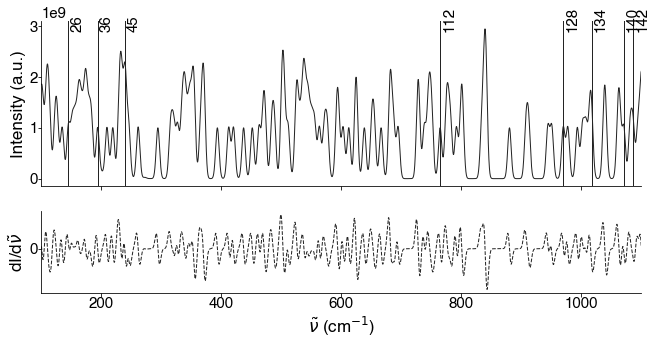

In [19]:
complex_to_load = 'as12'
com = load_complex(complex_to_load)
f, ax = plot_raman(com, mode='diff', wl=366, xlim=[100, 1100], modes_to_plot=[26, 36, 45, 112, 128, 134, 140, 142])
pu.save_figure(f, '../images/final-as12.pdf')

In [20]:
#list(sorted(com.uv_data.items(), key=lambda v:v[1]['f'], reverse=True))
com.uv_data

{1: {'nm': 1186.58, 'f': 0.0126},
 2: {'nm': 1061.31, 'f': 0.0141},
 3: {'nm': 901.4, 'f': 0.0076},
 4: {'nm': 794.27, 'f': 0.0089},
 5: {'nm': 739.96, 'f': 0.0266},
 6: {'nm': 708.17, 'f': 0.0261},
 7: {'nm': 695.93, 'f': 0.0126},
 8: {'nm': 662.42, 'f': 0.0037},
 9: {'nm': 638.62, 'f': 0.0052},
 10: {'nm': 599.78, 'f': 0.0117},
 11: {'nm': 580.07, 'f': 0.0327},
 12: {'nm': 548.3, 'f': 0.1972},
 13: {'nm': 542.04, 'f': 0.1383},
 14: {'nm': 514.57, 'f': 0.0346},
 15: {'nm': 500.04, 'f': 0.0476},
 16: {'nm': 475.3, 'f': 0.015},
 17: {'nm': 470.1, 'f': 0.0149},
 18: {'nm': 457.43, 'f': 0.0533},
 19: {'nm': 451.0, 'f': 0.0017},
 20: {'nm': 438.58, 'f': 0.0816},
 21: {'nm': 433.92, 'f': 0.0834},
 22: {'nm': 430.83, 'f': 0.0735},
 23: {'nm': 417.16, 'f': 0.0249},
 24: {'nm': 407.73, 'f': 0.1021},
 25: {'nm': 401.19, 'f': 0.105},
 26: {'nm': 398.07, 'f': 0.0158},
 27: {'nm': 387.67, 'f': 0.0178},
 28: {'nm': 385.52, 'f': 0.0317},
 29: {'nm': 377.51, 'f': 0.0102},
 30: {'nm': 375.01, 'f': 0.0

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


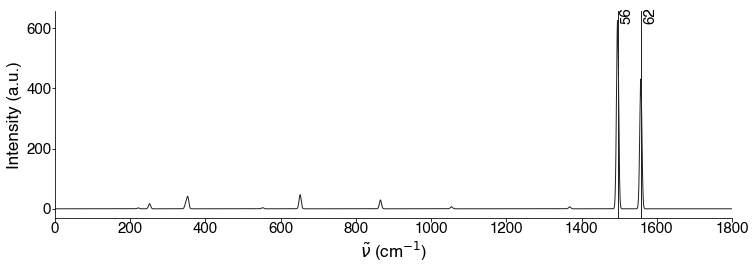

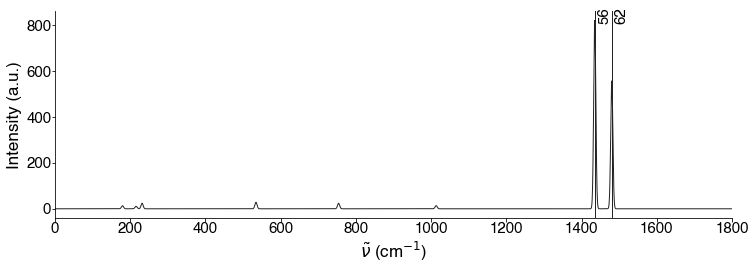

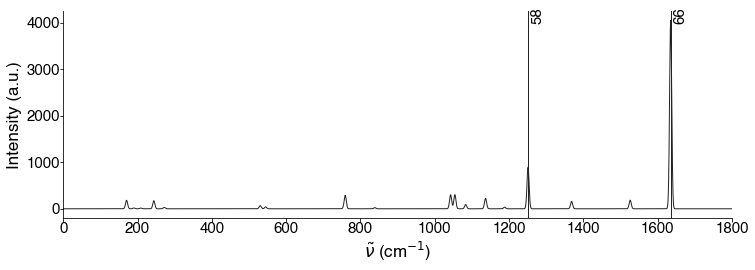

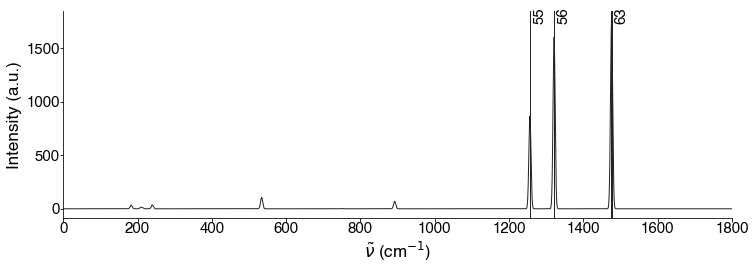

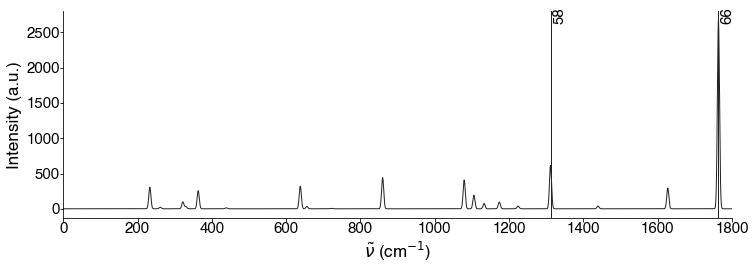

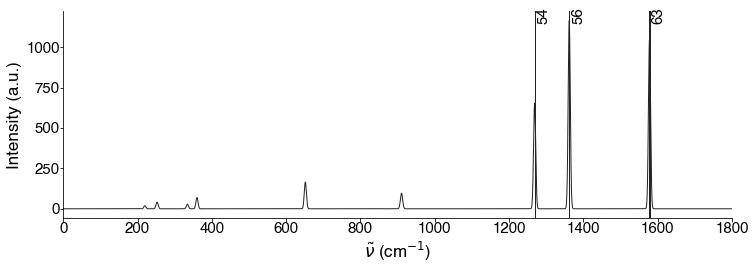

In [21]:
def flower_raman(name, mtp, mtl, xlim):  
    flow = load_flower(name)
    f, ax = plot_raman(system=flow, modes_to_plot=mtp, modes_to_label=mtl, height=4, xlim=xlim)
    pu.save_figure(f, '../images/raman-{}.pdf'.format(name))

flower_raman(name='s08', mtp=[56, 61, 62], mtl=[56, 62], xlim=[0, 1800])
flower_raman(name='se08', mtp=[56, 61, 62], mtl=[56, 62], xlim=[0, 1800])
flower_raman(name='as08', mtp=[58, 66], mtl='auto', xlim=[0, 1800])
flower_raman(name='asn08', mtp=[54, 55, 56, 62, 63], mtl=[55, 56, 63], xlim=[0, 1800])
flower_raman(name='p08', mtp=[58, 66], mtl='auto', xlim=[0, 1800])
flower_raman(name='pn08', mtp=[54, 56, 62, 63], mtl=[54, 56, 63], xlim=[0, 1800])

In [22]:
complex_to_load = 'as12'
com = load_complex(complex_to_load)

Number of atoms: 36


In [23]:
cool_modes, cool_nm, cool_range = vib_report(com, maxsur=0, minmol=95, minef=6.7)


Selection for as12-STX system


    Modes with maxsur= 0.00 and minmol=95.00
    [26, 36, 43, 45, 112, 128, 132, 134, 139, 140, 142]


    Wavelengths for minef= 6.71
    [366, 375, 408, 543, 549, 600, 639, 795]

     Mode range
    [100.0, 1100.0]


No handles with labels found to put in legend.


0.0 201.0
[22.0, 25.0, 36.0, 81.0, 83.0, 100.0, 112.99999999999999, 165.0]


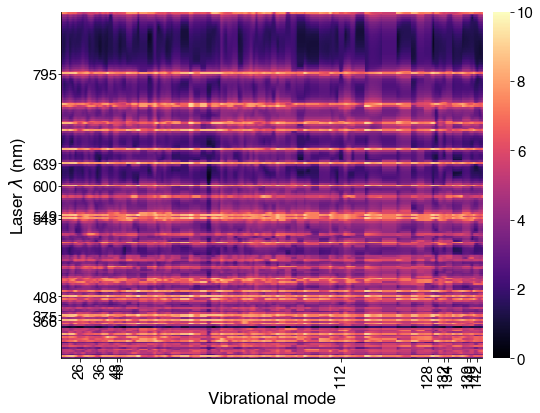

In [24]:
f, ax = plot_hm(com, xrange=cool_range, vmax=10, cmap='magma',
                cool_modes=cool_modes, cool_nm=cool_nm)
pu.save_figure(f, '../images/comb-{}.png'.format(complex_to_load))

Number of atoms: 36
(0.4941235294117647, 0.0, 0.5607647058823529, 1.0)
(0.0, 0.0, 0.7255235294117647, 1.0)
(0.0, 0.9163607843137255, 0.0, 1.0)
(0.9516098039215687, 0.8967078431372549, 0.0, 1.0)
(1.0, 0.27058823529411763, 0.0, 1.0)


No handles with labels found to put in legend.


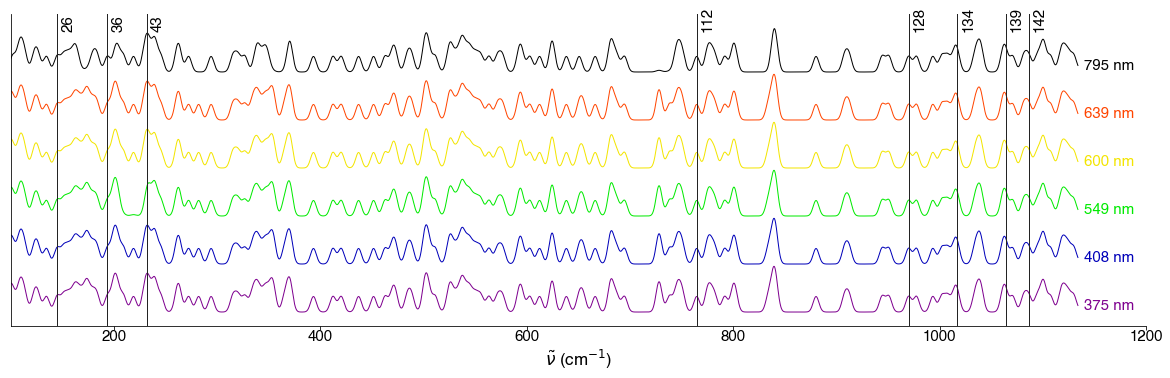

In [25]:
name = 'as12'
com = load_complex(name)
nms = [375, 408, 549, 600, 639, 795]
modes = [26, 36, 43, 112, 128, 134, 139, 142]
f, ax = plot_raman(com, rr_list=nms, mode='multirr', xlim=[100, 1200], modes_to_plot=modes, height=0.5*(len(modes) - 5) + 4, kind='wide', cmap_name='nipy_spectral')
pu.save_figure(f, '../images/unfolded-as12.pdf')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


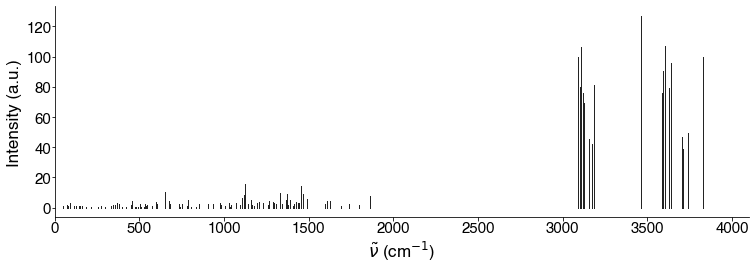

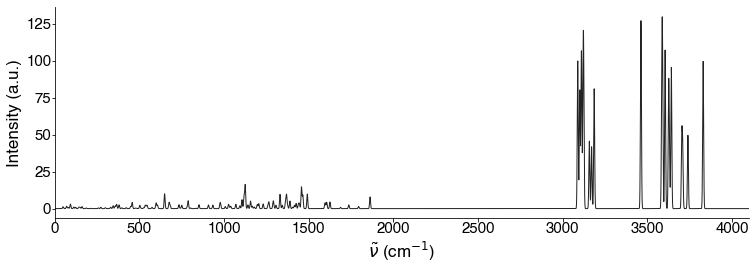

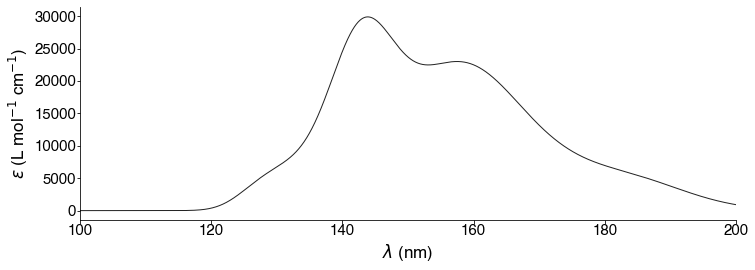

In [26]:
sys = System(name='STX')
sys.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/stx/uv-stx.log')
sys.get_wn('/Users/oscar/Dropbox/s3/flowers-and-stx/stx/raman-stx.log')
sys.load_raman('/Users/oscar/Dropbox/s3/flowers-and-stx/stx/raman-stx.log')
f, ax = plot_raman(sys, mode='skeleton', height=4)
pu.save_figure(f, '../images/without-envelope.pdf')
f, ax = plot_raman(sys, mode='SL', height=4)
pu.save_figure(f, '../images/with-envelope.pdf')
f, ax = plot_uv(sys, height=4)
pu.save_figure(f, '../images/uv-envelope.pdf')

No handles with labels found to put in legend.


[(24, 0.9281, 219.82), (25, 0.9281, 219.82), (30, 0.2623, 210.8), (31, 0.2623, 210.8), (38, 0.0017, 204.31), (1, 0.0, 272.87), (2, 0.0, 272.87), (3, 0.0, 252.39), (4, 0.0, 252.26), (5, 0.0, 252.25), (6, 0.0, 251.31), (7, 0.0, 251.01), (8, 0.0, 251.01), (9, 0.0, 247.37), (10, 0.0, 236.89), (11, 0.0, 236.89), (12, 0.0, 233.98), (13, 0.0, 233.98), (14, 0.0, 228.27), (15, 0.0, 228.27), (16, 0.0, 225.27), (17, 0.0, 224.79), (18, 0.0, 223.27), (19, 0.0, 223.1), (20, 0.0, 223.1), (21, 0.0, 221.55), (22, 0.0, 221.02), (23, 0.0, 221.02), (26, 0.0, 218.52), (27, 0.0, 218.52), (28, 0.0, 216.54), (29, 0.0, 216.53), (32, 0.0, 208.1), (33, 0.0, 207.66), (34, 0.0, 207.66), (35, 0.0, 207.23), (36, 0.0, 207.22), (37, 0.0, 206.64), (39, 0.0, 204.19), (40, 0.0, 204.19), (41, 0.0, 197.92), (42, 0.0, 197.52), (43, 0.0, 196.34), (44, 0.0, 196.34), (45, 0.0, 194.84), (46, 0.0, 194.84), (47, 0.0, 193.17), (48, 0.0, 190.66), (49, 0.0, 190.65), (50, 0.0, 185.44)]
[24, 25, 30, 31, 38]


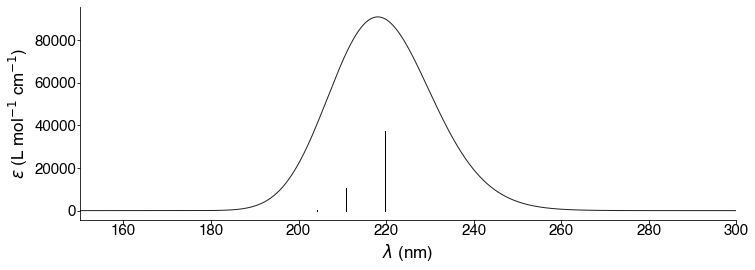

In [27]:
flow = load_flower('s08')
f, ax = plot_uv(flow, states_to_plot=5, height=4)
pu.save_figure(f, '../images/uv-s08-simple.pdf')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(5, 0.2648, 163.39), (17, 0.2274, 142.98), (8, 0.1636, 154.72), (6, 0.1256, 157.99), (15, 0.1253, 144.77), (14, 0.1046, 146.2), (18, 0.1003, 142.26), (1, 0.0918, 185.63), (3, 0.0858, 170.49), (7, 0.068, 155.98), (2, 0.0642, 175.76), (11, 0.0457, 150.42), (16, 0.0434, 143.65), (20, 0.0356, 140.81), (33, 0.0347, 133.91), (27, 0.0248, 136.81), (39, 0.0239, 130.38), (28, 0.016, 136.55), (19, 0.0159, 141.56), (13, 0.0156, 148.37), (21, 0.0152, 140.41), (47, 0.015, 126.63), (26, 0.0149, 137.21), (22, 0.0144, 139.74), (12, 0.0121, 148.6), (42, 0.0111, 128.8), (23, 0.0106, 138.58), (9, 0.0102, 153.4), (32, 0.0102, 134.0), (48, 0.01, 126.29), (38, 0.0099, 130.78), (10, 0.0086, 152.22), (41, 0.0083, 129.44), (45, 0.008, 127.38), (25, 0.0069, 137.93), (37, 0.0069, 131.43), (30, 0.0067, 135.02), (43, 0.0055, 128.03), (49, 0.0053, 126.16), (40, 0.0052, 130.02), (31, 0.0047, 134.28), (46, 0.0047, 127.27), (36, 0.0035, 131.83), (24, 0.0034, 138.45), (34, 0.0031, 133.04), (35, 0.003, 131.93), (29, 0.

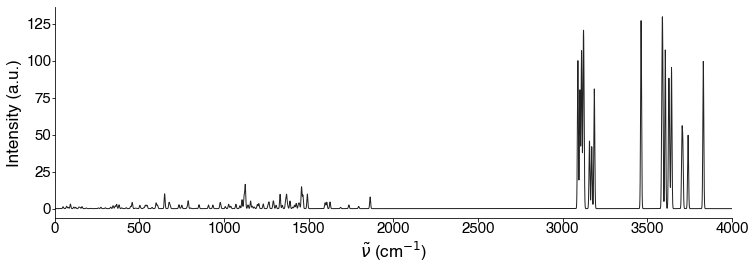

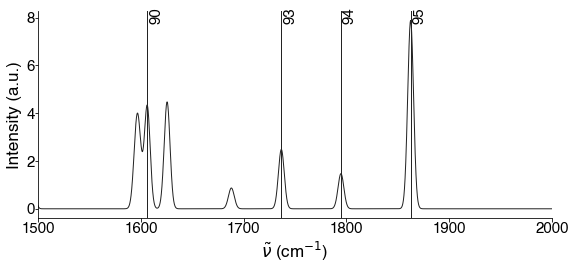

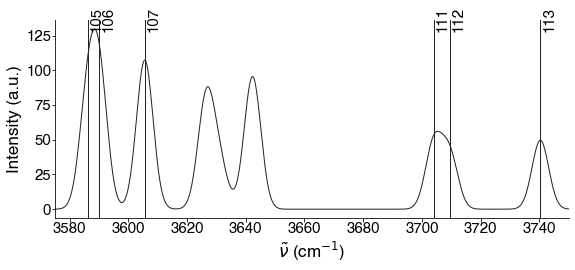

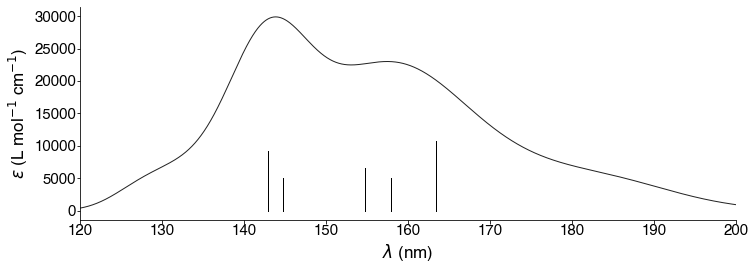

In [28]:
sys = System(name='STX')
sys.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/stx/uv-stx.log')
sys.get_wn('/Users/oscar/Dropbox/s3/flowers-and-stx/stx/raman-stx.log')
sys.load_raman('/Users/oscar/Dropbox/s3/flowers-and-stx/stx/raman-stx.log')
f, ax = plot_raman(sys, mode='SL', xlim=[0, 4000], height=4)
pu.save_figure(f, '../images/raman-stx.pdf')
f, ax = plot_raman(sys, mode='SL', xlim=[1500, 2000], height=4, modes_to_plot=[90, 93, 94, 95], kind='half-page')
pu.save_figure(f, '../images/raman-stx-left.pdf')
f, ax = plot_raman(sys, mode='SL', xlim=[3575, 3750], height=4, modes_to_plot=[105, 106, 107, 111, 112, 113], kind='half-page')
pu.save_figure(f, '../images/raman-stx-right.pdf')
f, ax = plot_uv(sys, states_to_plot=5, xlim=[120, 200], height=4)
pu.save_figure(f, '../images/uv-stx.pdf')

modes = [90, 91, 93, 94, 95, 105, 106, 107, 111, 112, 113]
for mode in modes:
    print(mode, round(sys.wn[mode - 1], ndigits=1))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(26, 0.364, 219.82), (22, 0.3252, 223.61), (24, 0.2385, 220.86), (28, 0.2181, 218.66), (19, 0.164, 226.76), (29, 0.143, 218.3), (16, 0.0949, 232.07), (18, 0.0485, 229.39), (17, 0.0435, 230.73), (15, 0.0434, 234.14), (30, 0.0347, 215.33), (14, 0.0295, 234.43), (23, 0.0292, 221.91), (33, 0.0291, 212.93), (13, 0.0151, 238.76), (21, 0.0145, 224.61), (34, 0.0144, 212.69), (3, 0.0137, 261.56), (27, 0.0105, 219.02), (12, 0.0104, 239.24), (31, 0.0104, 213.86), (4, 0.0072, 260.59), (36, 0.0072, 210.02), (49, 0.0068, 196.86), (37, 0.0052, 209.55), (8, 0.0043, 250.91), (7, 0.004, 252.06), (41, 0.0036, 205.83), (39, 0.0033, 207.18), (10, 0.0032, 241.03), (35, 0.0022, 210.84), (38, 0.0018, 208.05), (20, 0.0016, 225.5), (32, 0.0015, 213.67), (44, 0.0015, 202.14), (47, 0.0014, 199.63), (48, 0.0014, 199.06), (50, 0.0013, 195.6), (5, 0.001, 257.31), (46, 0.001, 201.32), (2, 0.0009, 272.4), (11, 0.0009, 240.02), (25, 0.0009, 220.31), (43, 0.0009, 203.53), (40, 0.0007, 207.05), (6, 0.0006, 254.61), (45,

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(12, 0.3803, 245.76), (11, 0.2909, 247.23), (15, 0.1266, 238.16), (9, 0.0931, 253.22), (10, 0.0773, 251.53), (16, 0.0709, 237.4), (18, 0.0658, 234.08), (13, 0.0542, 240.91), (14, 0.0352, 239.37), (17, 0.034, 236.61), (39, 0.0328, 216.86), (1, 0.0321, 279.89), (26, 0.0298, 227.14), (38, 0.0241, 217.88), (2, 0.0239, 278.52), (21, 0.0222, 231.02), (42, 0.0216, 213.94), (50, 0.0214, 205.84), (4, 0.018, 271.12), (37, 0.0169, 218.79), (40, 0.0141, 215.35), (22, 0.0137, 230.5), (28, 0.0137, 225.89), (33, 0.0124, 222.61), (20, 0.0117, 232.25), (25, 0.0108, 228.06), (45, 0.0091, 211.11), (41, 0.0089, 214.07), (49, 0.0087, 206.67), (5, 0.0077, 266.2), (7, 0.0074, 262.96), (27, 0.0073, 226.27), (31, 0.0072, 223.93), (48, 0.0072, 207.3), (35, 0.007, 221.58), (23, 0.0061, 230.08), (19, 0.0056, 232.51), (29, 0.0056, 225.44), (6, 0.0054, 265.5), (36, 0.0047, 220.86), (3, 0.0046, 272.29), (24, 0.0036, 229.66), (44, 0.0036, 211.74), (46, 0.0035, 210.31), (32, 0.0033, 223.27), (30, 0.0021, 224.7), (47,

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(22, 0.2051, 251.76), (21, 0.177, 255.3), (24, 0.1417, 249.96), (26, 0.0935, 247.27), (5, 0.0894, 326.74), (2, 0.0842, 365.22), (6, 0.0834, 325.66), (25, 0.0725, 248.41), (14, 0.0602, 275.73), (18, 0.0575, 262.74), (28, 0.0565, 245.94), (31, 0.0535, 242.08), (48, 0.0417, 225.44), (11, 0.0333, 290.97), (23, 0.0327, 251.01), (36, 0.0301, 236.91), (47, 0.0286, 226.18), (16, 0.0282, 265.82), (17, 0.0281, 263.44), (20, 0.0241, 259.53), (15, 0.023, 270.14), (13, 0.022, 278.57), (37, 0.0202, 236.1), (33, 0.0163, 240.04), (41, 0.0155, 231.5), (19, 0.0142, 260.62), (4, 0.0136, 345.21), (3, 0.0129, 347.56), (43, 0.0116, 229.6), (42, 0.0107, 230.13), (39, 0.0101, 233.58), (32, 0.0096, 240.5), (50, 0.0096, 223.66), (1, 0.0088, 372.99), (38, 0.0086, 235.28), (29, 0.0084, 244.65), (12, 0.0081, 288.84), (30, 0.007, 242.25), (44, 0.0069, 228.76), (40, 0.0064, 232.35), (46, 0.006, 227.6), (34, 0.0056, 238.95), (7, 0.0053, 305.61), (8, 0.0034, 301.94), (10, 0.0028, 297.02), (45, 0.0025, 228.38), (27, 0

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(29, 0.355, 237.95), (32, 0.2821, 235.14), (22, 0.1514, 243.41), (20, 0.139, 248.06), (23, 0.139, 242.94), (27, 0.1168, 239.88), (39, 0.1055, 224.39), (38, 0.102, 224.99), (19, 0.096, 249.8), (24, 0.0936, 241.51), (33, 0.0863, 233.76), (26, 0.0671, 240.52), (31, 0.0496, 236.56), (34, 0.041, 227.56), (30, 0.0306, 237.81), (25, 0.0263, 241.18), (35, 0.0186, 226.69), (17, 0.0175, 252.69), (40, 0.0172, 223.65), (16, 0.0084, 254.5), (36, 0.0079, 226.42), (18, 0.0064, 251.3), (1, 0.006, 286.32), (37, 0.0056, 225.66), (43, 0.0056, 219.05), (2, 0.0049, 284.96), (28, 0.0048, 239.03), (44, 0.0044, 218.44), (46, 0.0038, 216.38), (41, 0.0027, 220.8), (3, 0.0026, 278.09), (11, 0.0026, 264.18), (21, 0.0024, 247.75), (10, 0.0023, 265.17), (47, 0.0023, 215.79), (4, 0.0017, 277.52), (13, 0.0014, 263.1), (48, 0.001, 213.25), (45, 0.0009, 217.1), (50, 0.0009, 210.34), (8, 0.0007, 267.68), (9, 0.0006, 266.14), (42, 0.0006, 219.86), (49, 0.0006, 211.99), (12, 0.0005, 263.47), (15, 0.0005, 256.4), (7, 0.00

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(36, 0.154, 248.41), (34, 0.0833, 251.19), (11, 0.0746, 299.0), (38, 0.0691, 246.12), (1, 0.0631, 358.18), (2, 0.0596, 350.33), (10, 0.0583, 303.25), (35, 0.0577, 249.01), (39, 0.0565, 244.66), (4, 0.0534, 337.6), (12, 0.0497, 294.71), (14, 0.0489, 291.61), (29, 0.044, 259.11), (40, 0.0436, 243.62), (37, 0.0292, 247.59), (3, 0.0259, 339.74), (28, 0.0246, 264.48), (19, 0.0234, 278.22), (42, 0.0234, 241.35), (31, 0.023, 255.69), (41, 0.023, 242.2), (15, 0.0226, 288.97), (17, 0.0185, 286.41), (6, 0.0155, 320.75), (24, 0.0152, 270.77), (27, 0.0138, 264.9), (46, 0.0125, 236.75), (7, 0.0124, 317.41), (49, 0.0122, 232.92), (22, 0.0107, 273.71), (30, 0.0107, 257.18), (32, 0.0107, 255.2), (25, 0.0101, 268.46), (33, 0.0097, 253.1), (23, 0.009, 271.49), (44, 0.0085, 238.23), (5, 0.0078, 322.4), (45, 0.0074, 237.28), (43, 0.0073, 239.87), (13, 0.0065, 292.49), (20, 0.0056, 277.17), (21, 0.0055, 275.12), (16, 0.0049, 287.98), (47, 0.004, 235.94), (50, 0.0033, 231.63), (48, 0.0031, 235.14), (8, 0.0

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(39, 0.1147, 266.5), (40, 0.1044, 266.28), (2, 0.0999, 425.51), (41, 0.0789, 265.12), (5, 0.0774, 389.45), (32, 0.0688, 278.02), (6, 0.0631, 381.14), (43, 0.0606, 263.03), (46, 0.0481, 259.11), (13, 0.0364, 324.84), (16, 0.0356, 309.7), (37, 0.0336, 271.58), (44, 0.027, 261.7), (42, 0.0231, 264.51), (30, 0.0215, 280.71), (25, 0.021, 289.56), (36, 0.0201, 272.45), (12, 0.017, 330.9), (48, 0.0151, 256.78), (38, 0.0146, 269.98), (19, 0.0144, 301.95), (11, 0.0142, 332.29), (35, 0.0136, 273.54), (50, 0.0135, 255.15), (34, 0.0115, 275.54), (3, 0.0114, 415.34), (15, 0.0108, 318.92), (8, 0.0106, 350.17), (18, 0.0097, 302.89), (14, 0.0086, 321.69), (24, 0.0072, 290.04), (28, 0.007, 282.86), (33, 0.007, 275.73), (27, 0.0069, 285.21), (47, 0.0061, 257.47), (4, 0.0059, 405.47), (31, 0.0052, 279.93), (21, 0.0038, 294.92), (23, 0.0035, 293.46), (17, 0.0032, 305.86), (22, 0.0031, 293.91), (9, 0.0029, 348.6), (45, 0.0028, 260.24), (29, 0.0025, 281.21), (1, 0.0024, 446.26), (7, 0.0019, 354.36), (49, 0

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(26, 0.4792, 355.95), (25, 0.3108, 358.33), (24, 0.204, 359.6), (13, 0.1476, 401.25), (7, 0.1419, 547.41), (8, 0.1212, 543.9), (14, 0.1179, 400.67), (48, 0.0871, 272.38), (49, 0.0723, 271.66), (45, 0.0601, 279.69), (6, 0.0556, 766.97), (12, 0.0433, 419.51), (5, 0.0396, 796.35), (15, 0.0322, 397.86), (11, 0.0277, 429.79), (21, 0.0243, 372.52), (28, 0.0221, 345.97), (23, 0.0204, 360.15), (47, 0.0099, 276.9), (35, 0.0091, 313.04), (10, 0.0069, 463.42), (29, 0.0069, 340.56), (22, 0.0053, 369.66), (19, 0.0031, 378.72), (38, 0.003, 308.27), (34, 0.0029, 317.33), (39, 0.0028, 303.14), (16, 0.0026, 394.5), (27, 0.0015, 355.0), (17, 0.0013, 389.01), (9, 0.0012, 471.69), (20, 0.0011, 377.8), (50, 0.001, 267.01), (40, 0.0008, 298.7), (30, 0.0005, 330.68), (44, 0.0005, 286.78), (18, 0.0004, 388.01), (37, 0.0004, 310.89), (32, 0.0003, 322.32), (36, 0.0003, 312.25), (4, 0.0002, 858.5), (31, 0.0002, 324.19), (42, 0.0002, 292.71), (43, 0.0002, 292.39), (1, 0.0001, 1999.16), (2, 0.0001, 1887.69), (3, 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(15, 0.432, 451.84), (17, 0.3701, 431.12), (14, 0.2658, 454.42), (16, 0.2251, 436.8), (29, 0.1646, 355.02), (20, 0.1581, 380.92), (38, 0.1126, 329.2), (26, 0.0944, 360.32), (40, 0.0656, 323.47), (28, 0.0654, 356.34), (31, 0.0652, 344.93), (27, 0.0591, 359.73), (13, 0.0558, 497.35), (50, 0.0524, 300.24), (39, 0.0351, 325.43), (41, 0.0348, 323.38), (42, 0.0309, 322.38), (10, 0.0247, 598.68), (43, 0.0246, 321.14), (9, 0.0241, 602.17), (8, 0.0147, 607.52), (47, 0.0108, 306.7), (30, 0.0104, 349.19), (48, 0.0087, 304.34), (25, 0.0069, 362.13), (5, 0.0061, 689.51), (4, 0.0058, 701.76), (21, 0.0055, 379.79), (22, 0.005, 375.54), (12, 0.004, 499.19), (35, 0.0037, 333.99), (3, 0.0035, 733.57), (18, 0.0032, 386.51), (45, 0.0028, 311.69), (1, 0.0025, 1034.44), (11, 0.0025, 593.03), (23, 0.0024, 369.43), (34, 0.0024, 336.54), (36, 0.002, 332.68), (49, 0.0019, 304.15), (2, 0.0017, 1022.77), (46, 0.0017, 309.46), (24, 0.0016, 367.7), (19, 0.0011, 382.56), (32, 0.0011, 339.65), (44, 0.0009, 315.32), 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(12, 0.1972, 548.3), (13, 0.1383, 542.04), (31, 0.1317, 372.36), (25, 0.105, 401.19), (24, 0.1021, 407.73), (30, 0.0986, 375.01), (43, 0.0871, 344.04), (21, 0.0834, 433.92), (20, 0.0816, 438.58), (48, 0.0749, 335.68), (32, 0.0746, 366.8), (22, 0.0735, 430.83), (42, 0.0638, 347.14), (46, 0.0587, 336.78), (18, 0.0533, 457.43), (44, 0.0502, 342.09), (15, 0.0476, 500.04), (36, 0.0427, 360.1), (37, 0.0411, 356.11), (14, 0.0346, 514.57), (11, 0.0327, 580.07), (28, 0.0317, 385.52), (35, 0.0315, 362.27), (5, 0.0266, 739.96), (6, 0.0261, 708.17), (23, 0.0249, 417.16), (41, 0.023, 349.18), (39, 0.0226, 352.82), (33, 0.0194, 366.26), (38, 0.0182, 354.02), (49, 0.0182, 333.19), (27, 0.0178, 387.67), (40, 0.0175, 352.05), (34, 0.0159, 362.78), (26, 0.0158, 398.07), (16, 0.015, 475.3), (17, 0.0149, 470.1), (2, 0.0141, 1061.31), (47, 0.0136, 336.29), (1, 0.0126, 1186.58), (7, 0.0126, 695.93), (10, 0.0117, 599.78), (29, 0.0102, 377.51), (45, 0.0094, 340.01), (4, 0.0089, 794.27), (3, 0.0076, 901.4), (

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(18, 0.5106, 379.86), (19, 0.3877, 377.22), (23, 0.2367, 366.77), (25, 0.1373, 347.48), (21, 0.1193, 370.66), (26, 0.103, 346.13), (24, 0.0677, 349.33), (16, 0.0513, 402.27), (27, 0.051, 344.28), (15, 0.043, 404.41), (20, 0.0274, 372.85), (30, 0.0231, 324.94), (7, 0.0201, 447.19), (31, 0.0148, 321.68), (14, 0.0131, 407.29), (1, 0.0127, 498.12), (13, 0.0121, 409.1), (35, 0.01, 306.15), (33, 0.009, 311.46), (11, 0.0084, 419.05), (6, 0.0071, 459.46), (2, 0.0051, 482.65), (34, 0.0038, 310.97), (17, 0.0029, 384.37), (49, 0.0028, 270.45), (29, 0.0025, 328.51), (46, 0.0024, 275.66), (50, 0.0024, 268.98), (22, 0.0021, 369.84), (28, 0.0017, 337.35), (5, 0.0016, 465.71), (9, 0.0016, 426.71), (36, 0.0015, 304.82), (4, 0.0012, 469.22), (12, 0.0012, 417.51), (39, 0.0012, 294.02), (32, 0.0011, 318.57), (40, 0.0011, 293.72), (8, 0.001, 433.03), (47, 0.001, 272.24), (48, 0.0009, 271.39), (45, 0.0007, 278.47), (10, 0.0005, 423.51), (38, 0.0005, 295.49), (3, 0.0003, 474.33), (41, 0.0003, 287.2), (37, 0

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(1, 0.1274, 628.84), (15, 0.126, 473.82), (27, 0.1131, 393.09), (30, 0.1039, 385.78), (48, 0.1001, 321.89), (16, 0.0889, 469.41), (21, 0.0772, 432.19), (20, 0.0732, 435.06), (47, 0.0731, 326.64), (22, 0.0715, 424.83), (3, 0.0706, 576.04), (26, 0.0628, 397.55), (2, 0.0574, 617.84), (23, 0.0572, 415.54), (32, 0.0384, 372.45), (35, 0.0369, 357.8), (18, 0.0347, 451.53), (44, 0.0344, 331.68), (45, 0.034, 328.78), (34, 0.0305, 363.02), (17, 0.0288, 456.25), (28, 0.0273, 388.96), (25, 0.0272, 411.59), (46, 0.0161, 327.46), (4, 0.0155, 553.91), (11, 0.0154, 494.49), (41, 0.0138, 338.92), (29, 0.0135, 386.95), (10, 0.0123, 505.4), (49, 0.0122, 320.26), (38, 0.0117, 348.04), (7, 0.0113, 515.96), (9, 0.01, 508.78), (19, 0.0099, 435.7), (12, 0.0096, 483.71), (33, 0.0092, 371.12), (31, 0.009, 379.48), (36, 0.0085, 356.36), (6, 0.0074, 520.93), (40, 0.0058, 343.07), (14, 0.0051, 481.39), (13, 0.005, 481.92), (5, 0.0049, 544.25), (43, 0.0049, 332.32), (50, 0.0047, 318.18), (42, 0.0034, 336.12), (37,

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(34, 0.2136, 429.92), (32, 0.0957, 438.5), (19, 0.0894, 495.77), (3, 0.0818, 708.23), (40, 0.0818, 405.46), (9, 0.0749, 574.91), (16, 0.0662, 512.12), (22, 0.066, 482.93), (48, 0.0606, 374.26), (45, 0.0588, 380.88), (46, 0.0527, 377.89), (35, 0.0503, 429.68), (38, 0.0445, 408.77), (2, 0.0387, 813.23), (13, 0.0386, 531.63), (12, 0.0336, 534.96), (44, 0.033, 382.96), (43, 0.0301, 385.15), (50, 0.0256, 365.46), (49, 0.0252, 371.74), (24, 0.0242, 473.14), (47, 0.0209, 375.38), (10, 0.0207, 556.08), (4, 0.0197, 688.95), (11, 0.0195, 544.83), (23, 0.0192, 476.35), (5, 0.0179, 630.02), (14, 0.0146, 523.56), (28, 0.0144, 454.6), (36, 0.0139, 421.32), (18, 0.0126, 501.93), (7, 0.0124, 592.51), (26, 0.0121, 461.69), (39, 0.0113, 405.85), (1, 0.0107, 842.77), (20, 0.0105, 490.87), (30, 0.0101, 446.96), (41, 0.0101, 402.18), (29, 0.0084, 450.38), (27, 0.0078, 459.78), (37, 0.0076, 413.27), (31, 0.0064, 443.06), (15, 0.0062, 519.84), (33, 0.0055, 437.29), (42, 0.0041, 390.92), (17, 0.0039, 505.1),

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(28, 0.3846, 322.74), (27, 0.3802, 323.89), (26, 0.1481, 324.17), (7, 0.1461, 496.87), (8, 0.1409, 493.46), (18, 0.1188, 377.93), (19, 0.1086, 376.72), (30, 0.1081, 314.58), (5, 0.0375, 762.7), (50, 0.0318, 258.19), (16, 0.0279, 395.21), (20, 0.0245, 371.88), (4, 0.0226, 784.33), (25, 0.0205, 330.25), (22, 0.0155, 363.72), (6, 0.0144, 739.03), (17, 0.0122, 394.77), (34, 0.0116, 301.65), (47, 0.0116, 265.79), (33, 0.0095, 302.44), (24, 0.008, 338.21), (29, 0.0055, 315.65), (31, 0.0053, 314.09), (46, 0.0051, 266.93), (42, 0.005, 277.27), (38, 0.0046, 289.57), (10, 0.0044, 447.61), (15, 0.0041, 404.7), (9, 0.0026, 454.58), (36, 0.0025, 298.25), (41, 0.0018, 282.89), (23, 0.0017, 348.68), (40, 0.0016, 285.72), (21, 0.0013, 368.03), (35, 0.0008, 300.17), (44, 0.0008, 276.06), (39, 0.0006, 288.67), (3, 0.0005, 1199.85), (11, 0.0005, 432.84), (48, 0.0004, 260.37), (12, 0.0003, 431.49), (14, 0.0003, 410.46), (1, 0.0002, 2832.81), (43, 0.0002, 276.59), (2, 0.0001, 1903.46), (13, 0.0001, 424.82

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(16, 0.6541, 391.45), (17, 0.6464, 389.29), (31, 0.2633, 327.63), (35, 0.22, 319.22), (32, 0.1921, 325.82), (18, 0.167, 374.97), (33, 0.1527, 322.96), (36, 0.0943, 312.86), (19, 0.0817, 371.19), (34, 0.069, 320.72), (27, 0.0487, 343.08), (37, 0.0398, 307.65), (13, 0.0224, 453.91), (28, 0.0181, 337.78), (8, 0.0137, 560.44), (12, 0.0114, 464.95), (38, 0.0114, 306.69), (9, 0.0112, 543.98), (49, 0.0097, 269.19), (30, 0.0095, 334.79), (44, 0.0094, 276.5), (23, 0.009, 352.07), (11, 0.0069, 494.92), (45, 0.0067, 274.86), (50, 0.0067, 268.29), (14, 0.0064, 424.65), (20, 0.0064, 368.86), (48, 0.0064, 269.6), (4, 0.0063, 623.53), (7, 0.0052, 584.63), (10, 0.0049, 506.35), (26, 0.0043, 344.31), (21, 0.0038, 364.56), (24, 0.0037, 350.39), (15, 0.0032, 415.65), (5, 0.003, 618.37), (47, 0.0028, 270.43), (46, 0.0024, 273.37), (25, 0.0023, 349.22), (42, 0.002, 290.71), (6, 0.0015, 590.78), (22, 0.0014, 353.24), (43, 0.001, 289.14), (39, 0.0009, 301.3), (41, 0.0009, 294.69), (29, 0.0004, 336.11), (2, 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(12, 0.2811, 492.32), (22, 0.2652, 383.23), (16, 0.2065, 444.71), (15, 0.1572, 446.59), (11, 0.1493, 496.92), (17, 0.1252, 443.96), (19, 0.1124, 402.32), (49, 0.1034, 307.79), (48, 0.0952, 307.93), (44, 0.0668, 316.96), (20, 0.0594, 399.52), (30, 0.0589, 352.25), (50, 0.0589, 303.59), (45, 0.0588, 316.15), (21, 0.0549, 397.62), (37, 0.0521, 332.53), (40, 0.0509, 324.94), (42, 0.0438, 318.91), (41, 0.0379, 321.43), (13, 0.0317, 482.19), (35, 0.0314, 341.57), (46, 0.0264, 316.05), (6, 0.0233, 658.53), (34, 0.0193, 342.57), (8, 0.0186, 588.65), (47, 0.01, 313.97), (4, 0.0075, 745.19), (1, 0.0062, 1241.85), (32, 0.0059, 351.12), (38, 0.0037, 329.39), (31, 0.0034, 351.68), (43, 0.0032, 317.85), (27, 0.003, 362.48), (39, 0.0028, 327.98), (14, 0.0027, 451.2), (26, 0.0016, 363.16), (7, 0.0011, 613.37), (28, 0.001, 356.93), (29, 0.0007, 353.75), (18, 0.0006, 406.09), (33, 0.0006, 349.0), (10, 0.0003, 514.16), (25, 0.0002, 364.7), (36, 0.0002, 340.27), (3, 0.0001, 1024.81), (5, 0.0001, 720.09),

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(17, 0.5108, 354.58), (16, 0.3535, 357.96), (22, 0.1364, 332.25), (23, 0.0958, 327.23), (25, 0.093, 322.61), (8, 0.0836, 378.11), (9, 0.0752, 376.0), (24, 0.0637, 324.0), (12, 0.048, 371.51), (10, 0.0428, 374.99), (7, 0.0402, 391.66), (29, 0.0394, 303.84), (15, 0.0385, 363.09), (18, 0.0369, 349.38), (4, 0.0348, 417.39), (28, 0.0283, 310.37), (13, 0.0276, 368.88), (6, 0.0265, 399.74), (2, 0.0242, 449.4), (21, 0.0222, 334.94), (11, 0.0221, 371.9), (5, 0.0189, 410.92), (30, 0.0182, 302.04), (32, 0.015, 297.73), (1, 0.0131, 451.34), (19, 0.0103, 343.42), (20, 0.0084, 337.36), (14, 0.0075, 365.85), (42, 0.0052, 263.34), (44, 0.0027, 257.19), (33, 0.0025, 296.3), (34, 0.0024, 279.47), (40, 0.0023, 267.75), (45, 0.0017, 255.56), (31, 0.0016, 299.41), (38, 0.0014, 269.31), (41, 0.0014, 266.23), (47, 0.0014, 251.66), (43, 0.0012, 262.74), (48, 0.001, 248.55), (49, 0.0008, 247.73), (27, 0.0007, 314.89), (3, 0.0006, 430.78), (37, 0.0006, 271.21), (39, 0.0006, 268.01), (26, 0.0005, 316.02), (50, 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(21, 0.2019, 393.47), (11, 0.1955, 430.88), (23, 0.1518, 384.1), (14, 0.0916, 421.39), (20, 0.0907, 398.62), (15, 0.082, 415.89), (3, 0.0812, 487.21), (37, 0.0752, 325.82), (31, 0.0731, 347.8), (2, 0.0576, 503.94), (8, 0.0575, 436.91), (12, 0.0574, 428.09), (28, 0.0529, 365.4), (13, 0.0482, 425.0), (32, 0.0425, 339.09), (38, 0.0423, 321.16), (6, 0.0377, 456.34), (1, 0.0353, 533.79), (24, 0.0344, 375.08), (30, 0.033, 352.74), (33, 0.0321, 335.75), (19, 0.0314, 400.37), (22, 0.0223, 387.19), (34, 0.0223, 335.25), (29, 0.0204, 357.64), (36, 0.0193, 329.41), (26, 0.0183, 368.31), (9, 0.0173, 433.43), (5, 0.0166, 464.33), (27, 0.0128, 367.44), (39, 0.0125, 320.64), (40, 0.0104, 317.02), (25, 0.0099, 371.41), (41, 0.0097, 313.8), (35, 0.0093, 331.57), (10, 0.0089, 431.93), (17, 0.0067, 409.64), (16, 0.0064, 412.76), (43, 0.0058, 306.85), (49, 0.0046, 291.62), (50, 0.0042, 289.73), (46, 0.0037, 300.17), (47, 0.0033, 296.33), (18, 0.0032, 405.21), (45, 0.003, 304.25), (42, 0.0025, 311.52), (4

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[(6, 0.1742, 530.54), (23, 0.1357, 417.91), (17, 0.114, 439.67), (18, 0.1031, 437.22), (28, 0.1027, 402.99), (30, 0.1008, 391.26), (21, 0.0904, 426.58), (2, 0.0764, 618.98), (5, 0.0715, 532.05), (27, 0.0644, 404.2), (13, 0.0546, 460.03), (16, 0.0537, 443.73), (29, 0.0492, 398.68), (25, 0.0437, 410.22), (44, 0.0427, 346.77), (49, 0.0416, 337.27), (4, 0.041, 606.17), (48, 0.0364, 339.58), (32, 0.0351, 385.45), (7, 0.0345, 509.77), (41, 0.0343, 354.84), (11, 0.0338, 469.63), (12, 0.0322, 469.2), (40, 0.0294, 357.77), (34, 0.0287, 380.42), (3, 0.0273, 613.59), (42, 0.0266, 354.13), (15, 0.0238, 446.09), (31, 0.022, 388.85), (14, 0.0216, 457.86), (33, 0.0209, 381.41), (35, 0.0194, 375.28), (47, 0.0193, 340.99), (46, 0.0179, 342.58), (9, 0.017, 489.29), (26, 0.0168, 407.59), (38, 0.0098, 365.98), (10, 0.0092, 482.98), (24, 0.009, 415.96), (22, 0.0076, 424.38), (8, 0.0066, 490.4), (36, 0.0064, 372.55), (39, 0.0059, 363.19), (1, 0.0055, 660.3), (45, 0.004, 343.7), (20, 0.0032, 431.39), (37, 0.

(<Figure size 594x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x117bd0630>)

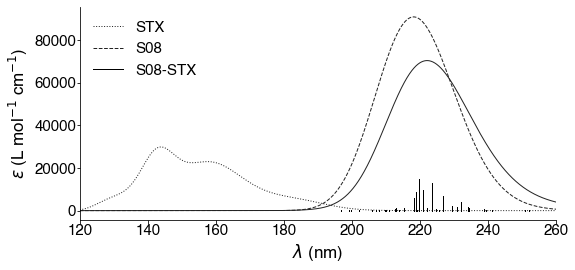

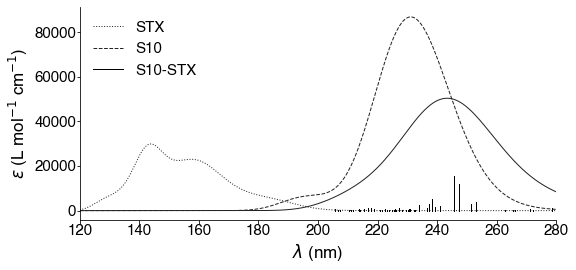

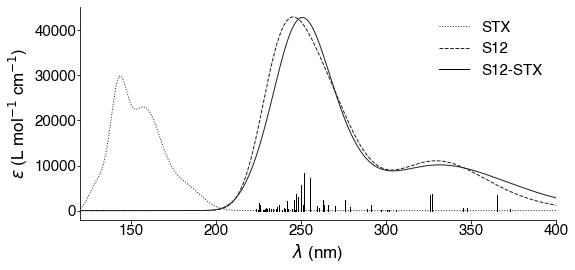

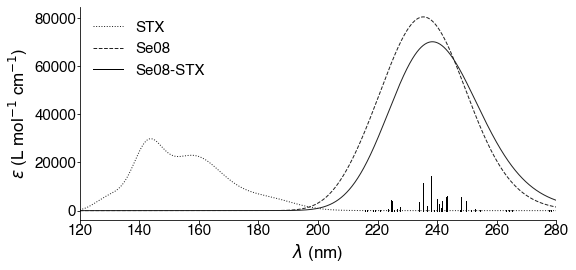

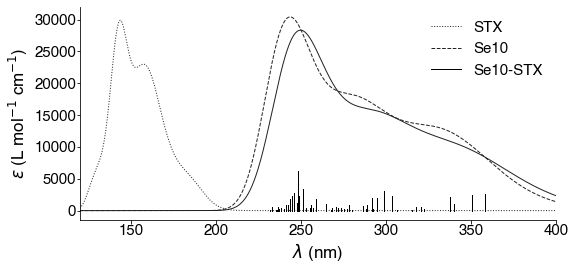

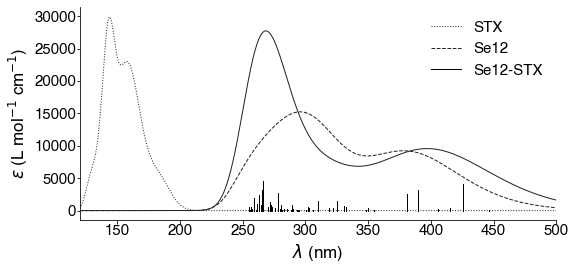

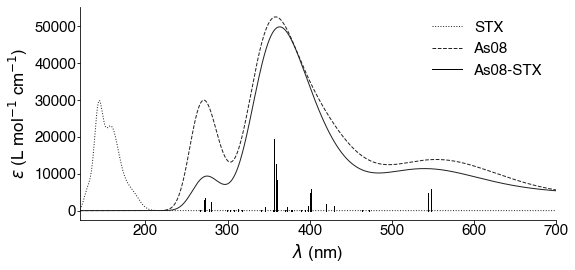

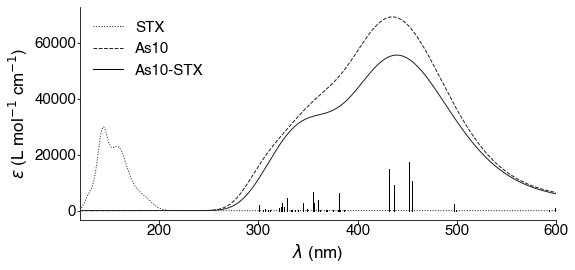

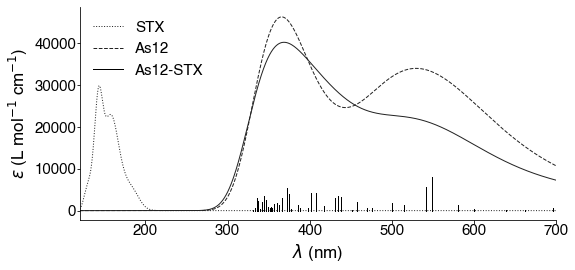

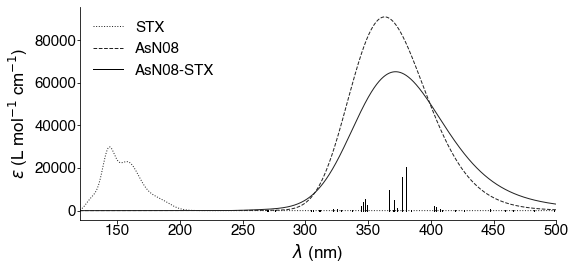

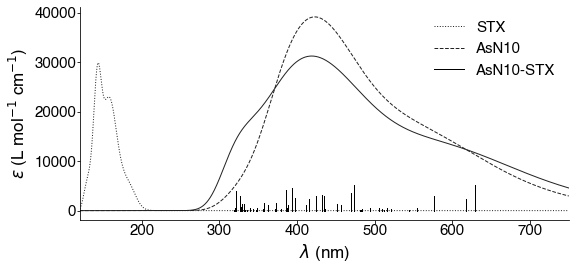

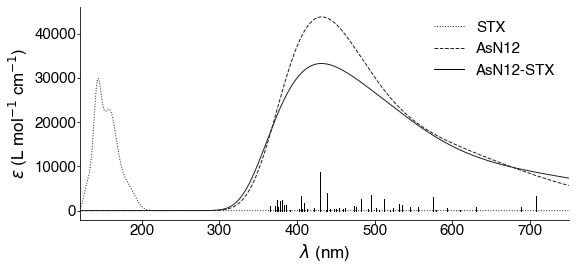

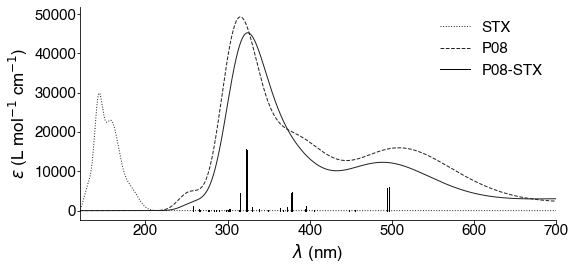

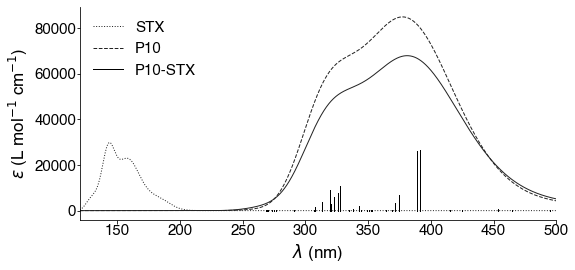

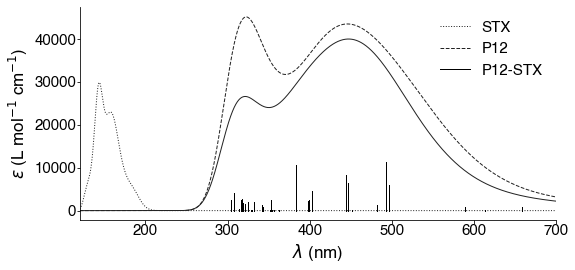

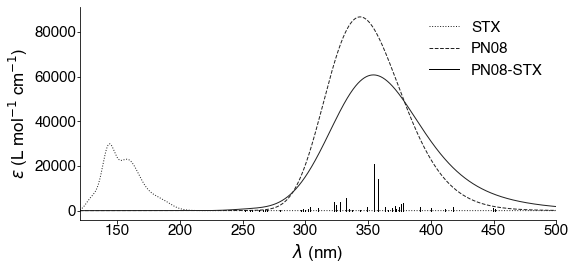

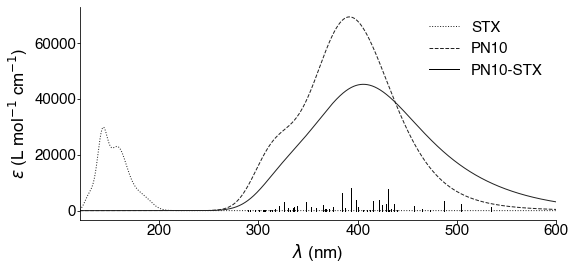

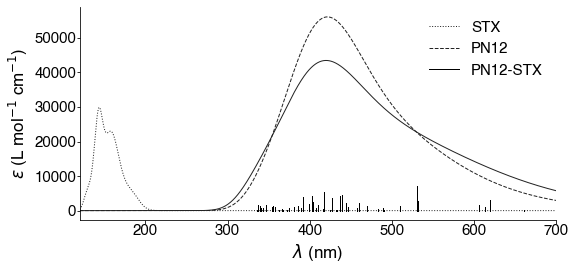

In [29]:
def compare_uv(sys, xlim=None):
    stx = System(name='STX')
    stx.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/stx/uv-stx.log')
    flow = System(name=sys)
    flow.load_uv('/Users/oscar/Dropbox/s3/flowers/uv/uv_{}.log'.format(sys))
    com = System(name='{}-STX'.format(sys))
    com.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/single-uv/uv-{}stx.out'.format(sys, sys))
    f, ax = pu.new_figure(height=4, kind='half-page')
    f, ax = plot_uv(stx, f=f, ax=ax, linestyle=':', xlim=xlim, label='STX')
    f, ax = plot_uv(flow, f=f, ax=ax, linestyle='--', xlim=xlim, label=sys)
    f, ax = plot_uv(com, f=f, ax=ax, linestyle='-', xlim=xlim, label='{}-STX'.format(sys), states_to_plot=50)
    
    lines = ax.get_lines()
    legend1 = plt.legend(lines, ['STX', sys, '{}-STX'.format(sys)],  loc=0, frameon=False)
    
    pu.save_figure(f, '../images/uv-{}.pdf'.format(flow.name))
    
    return f, ax

compare_uv('S08', xlim=[120, 260])
compare_uv('S10', xlim=[120, 280])
compare_uv('S12', xlim=[120, 400])
compare_uv('Se08', xlim=[120, 280])
compare_uv('Se10', xlim=[120, 400])
compare_uv('Se12', xlim=[120, 500])
compare_uv('As08', xlim=[120, 700])
compare_uv('As10', xlim=[120, 600])
compare_uv('As12', xlim=[120, 700])
compare_uv('AsN08', xlim=[120, 500])
compare_uv('AsN10', xlim=[120, 750])
compare_uv('AsN12', xlim=[120, 750])
compare_uv('P08', xlim=[120, 700])
compare_uv('P10', xlim=[120, 500])
compare_uv('P12', xlim=[120, 700])
compare_uv('PN08', xlim=[120, 500])
compare_uv('PN10', xlim=[120, 600])
compare_uv('PN12', xlim=[120, 700])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


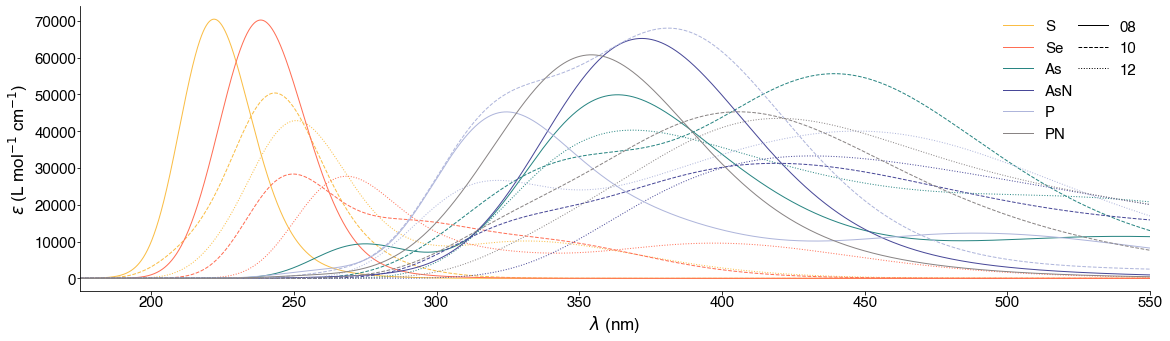

In [4]:
def plot_uv_list(sys_list, petal_list, good_threshold=300):
    uv_list = [a + b for a in sys_list for b in petal_list]
    f, ax = pu.new_figure(height=5, kind='wide')
    for sys in sys_list:
        for petals in petal_list:
            name = sys + petals
            com = System(name=name)
            com.load_uv('/Users/oscar/Dropbox/s3/flowers-and-stx/single-uv/uv-{}stx.out'.format(name, name))
            #com.load_uv('/Users/oscar/Dropbox/s3/flowers/uv/uv_{}.log'.format(name))
            f, ax = plot_uv(com, f=f, ax=ax, main_color=pu.sys_colors[sys],
                            xlim=[175, 550], linestyle=pu.petal_styles[petals], label=name)
    #ax.fill_betweenx(y=[70000, 70000], x1=good_threshold, x2=0, alpha=0.5, color='black')
    
    lines = ax.get_lines()
    legend1 = plt.legend(lines[::3], ['S', 'Se', 'As', 'AsN', 'P', 'PN'], loc=0, frameon=False, bbox_to_anchor=(0.85, 0.48))
    
    dummy_lines = []
    for style in ['-', '--', ':']:
        dummy_lines.append(ax.plot([],[], c="black", ls=style)[0])
    legend2 = plt.legend(dummy_lines, ["08", "10", "12"], loc=0, frameon=False)
    
    ax.add_artist(legend1)
    
    #pu.tuftefy(ax)
    return f, ax

sys_list = ['s', 'se', 'as', 'asn', 'p', 'pn']
petal_list = ['08', '10', '12']

f, ax = plot_uv_list(sys_list, petal_list)
pu.save_figure(f, '../images/complex-uv.pdf')